In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
import IPython
import numpy as np

rng = np.random.default_rng(1999)

# Example 1: Polynomial regression

Consider a model with three parameters
\begin{equation*}
y = \theta_0 + \theta_1 x + \theta_2 x^2 + \epsilon,
\end{equation*}

where $\epsilon$ is a gaussian random variable with mean zero.


In [2]:
# Create theoretical model with three parameters
def model(theta, x):
    return theta[0] + theta[1] * x + theta[2] * x ** 2

#Choose inpute parameters
theta = [-0.51, 0.37, 0.084]

<ErrorbarContainer object of 3 artists>

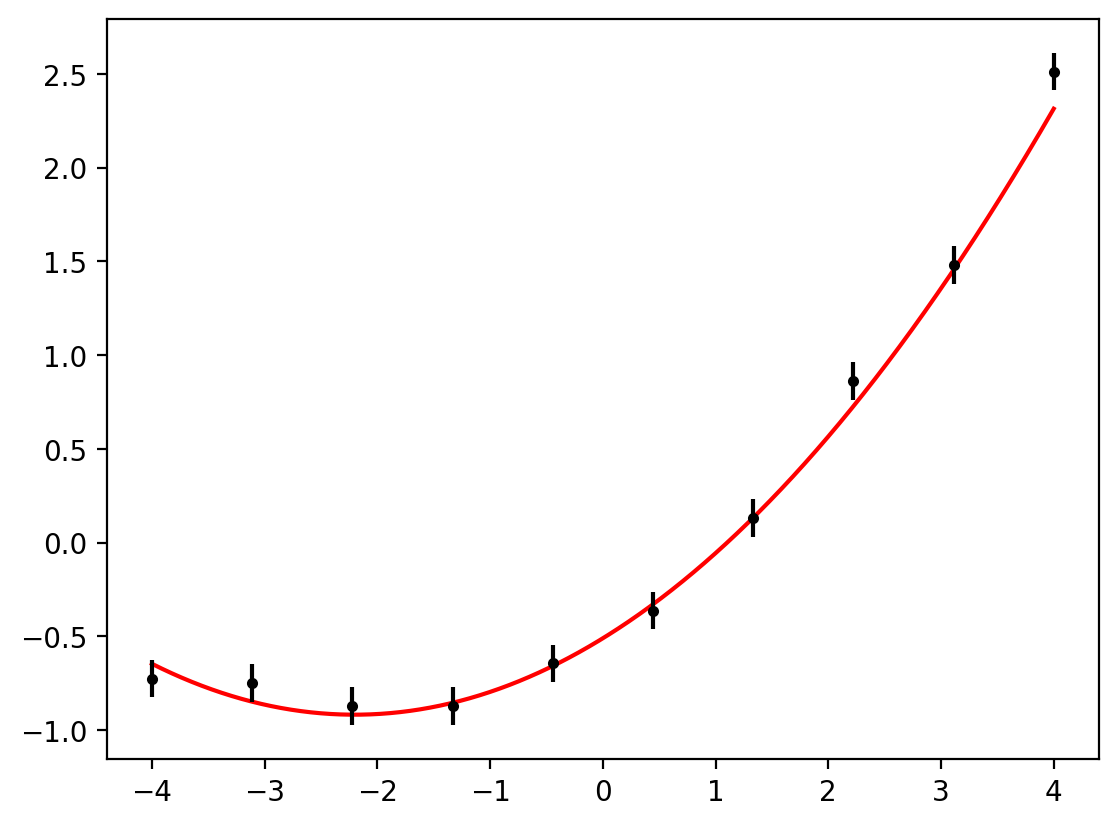

In [3]:
# Generate data
sigma = 0.1
n_data = 10
x_data = np.linspace(-4, 4, n_data)
y_data = model(theta, x_data) + rng.normal(0, sigma, n_data)

# Plot data
x_plot = np.linspace(-4, 4, 1000)
y_plot = model(theta, x_plot)

plt.plot(x_plot, y_plot, color = 'red')
plt.errorbar(x_data, y_data, yerr=sigma, fmt = '.', color = 'black')

In [4]:
# Fisher matrix

f_matrix = np.zeros((3, 3))
for i in range(3):
    for j in range(3):
        f_matrix[i, j] = np.sum(1 / sigma ** 2 * x_data ** i * x_data ** j)

print(f_matrix)

# Inverse Fisher matrix
f_matrix_inv = np.linalg.inv(f_matrix)
print()
print(f_matrix_inv)


[[ 1.00000000e+03 -1.13686838e-13  6.51851852e+03]
 [-1.13686838e-13  6.51851852e+03 -4.54747351e-12]
 [ 6.51851852e+03 -4.54747351e-12  7.54538637e+04]]

[[ 2.28906250e-03 -9.80352163e-20 -1.97753906e-04]
 [-9.80352163e-20  1.53409091e-04  1.77150391e-20]
 [-1.97753906e-04  1.77150391e-20  3.03372470e-05]]


Removed no burn in


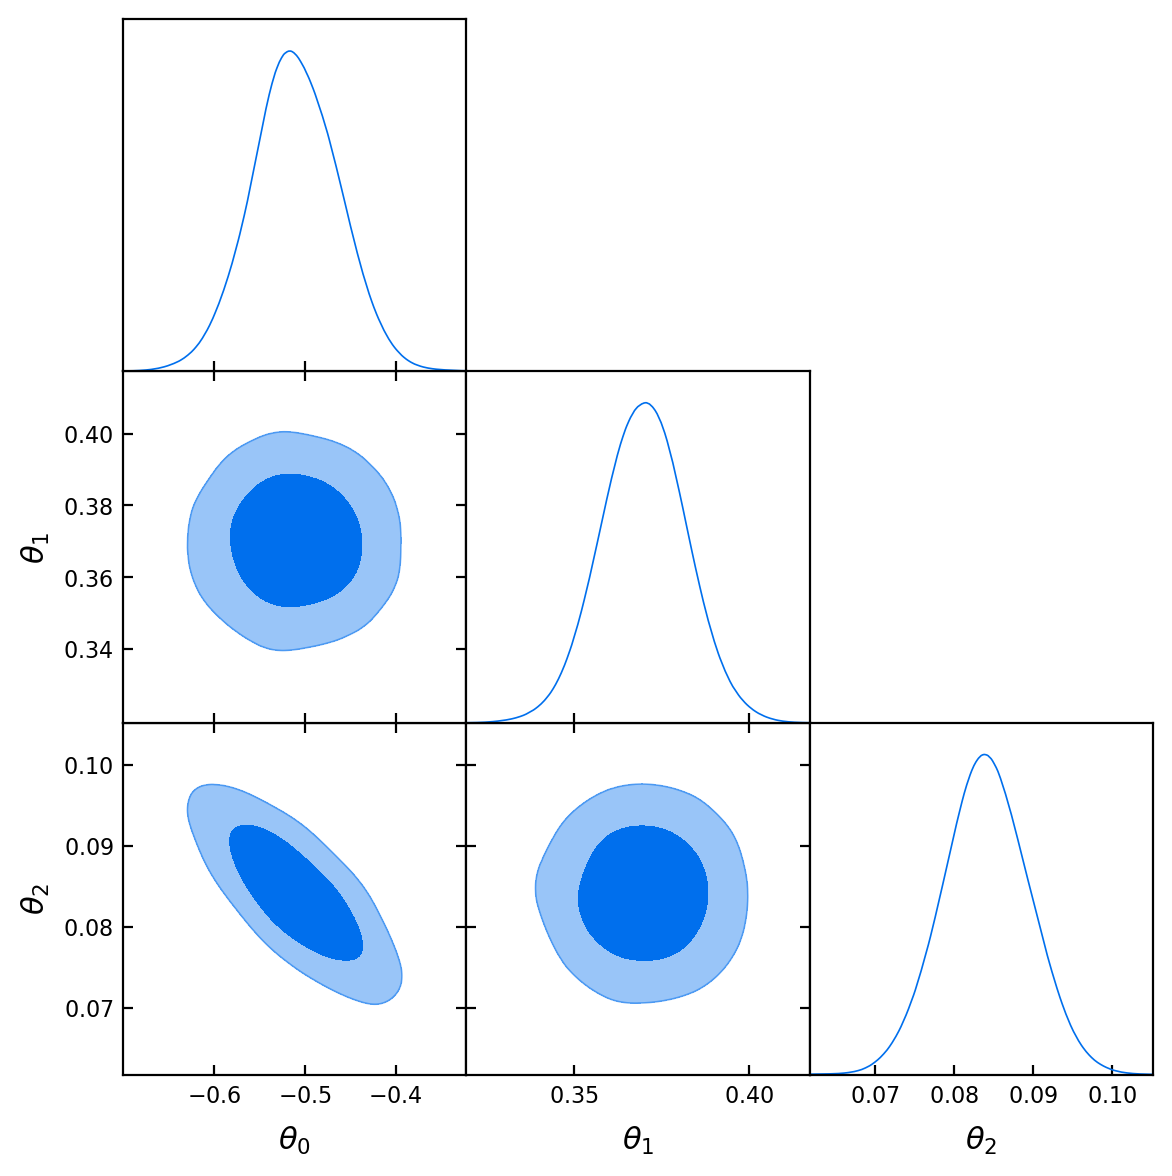

In [5]:
# Plot corner plots from the Fisher matrix

chain = rng.multivariate_normal(theta, f_matrix_inv, 10000)
names = [r"\theta%s"%i for i in range(3)]
labels =  [r"\theta_%s"%i for i in range(3)]
samples_fisher = MCSamples(samples=chain,names = names, labels = labels)
g = plots.get_subplot_plotter()
g.triangle_plot([samples_fisher], filled=True)

In [6]:
# Save data in .txt file for the sampler
np.savetxt('./data/data3p.txt', np.array([x_data, y_data]).T)
np.savetxt("./data/data_cov_matrix3p.txt", np.diag([sigma ** 2 for i in range(n_data)]))
np.savetxt("./data/fisher3p.txt", f_matrix)
np.savetxt("./data/fisher_inv3p.txt", f_matrix_inv) 

In [7]:
# Type gcc three_parameters.c -L../source -o tp -lmcmcsim `gsl-config --cflags --libs` in the command-line
# Run ./tp in the command-line
# After running the MCMC, we can load the chains and plot the results
n_param = 3 # Number of parameters
n_chain = 200000 # Number of samples in the chain
chain = np.fromfile("./output/chain.bin")
post = np.fromfile("./output/posterior.bin")
chain = chain.reshape((n_chain,n_param))

min logpost: 1.931987123897251


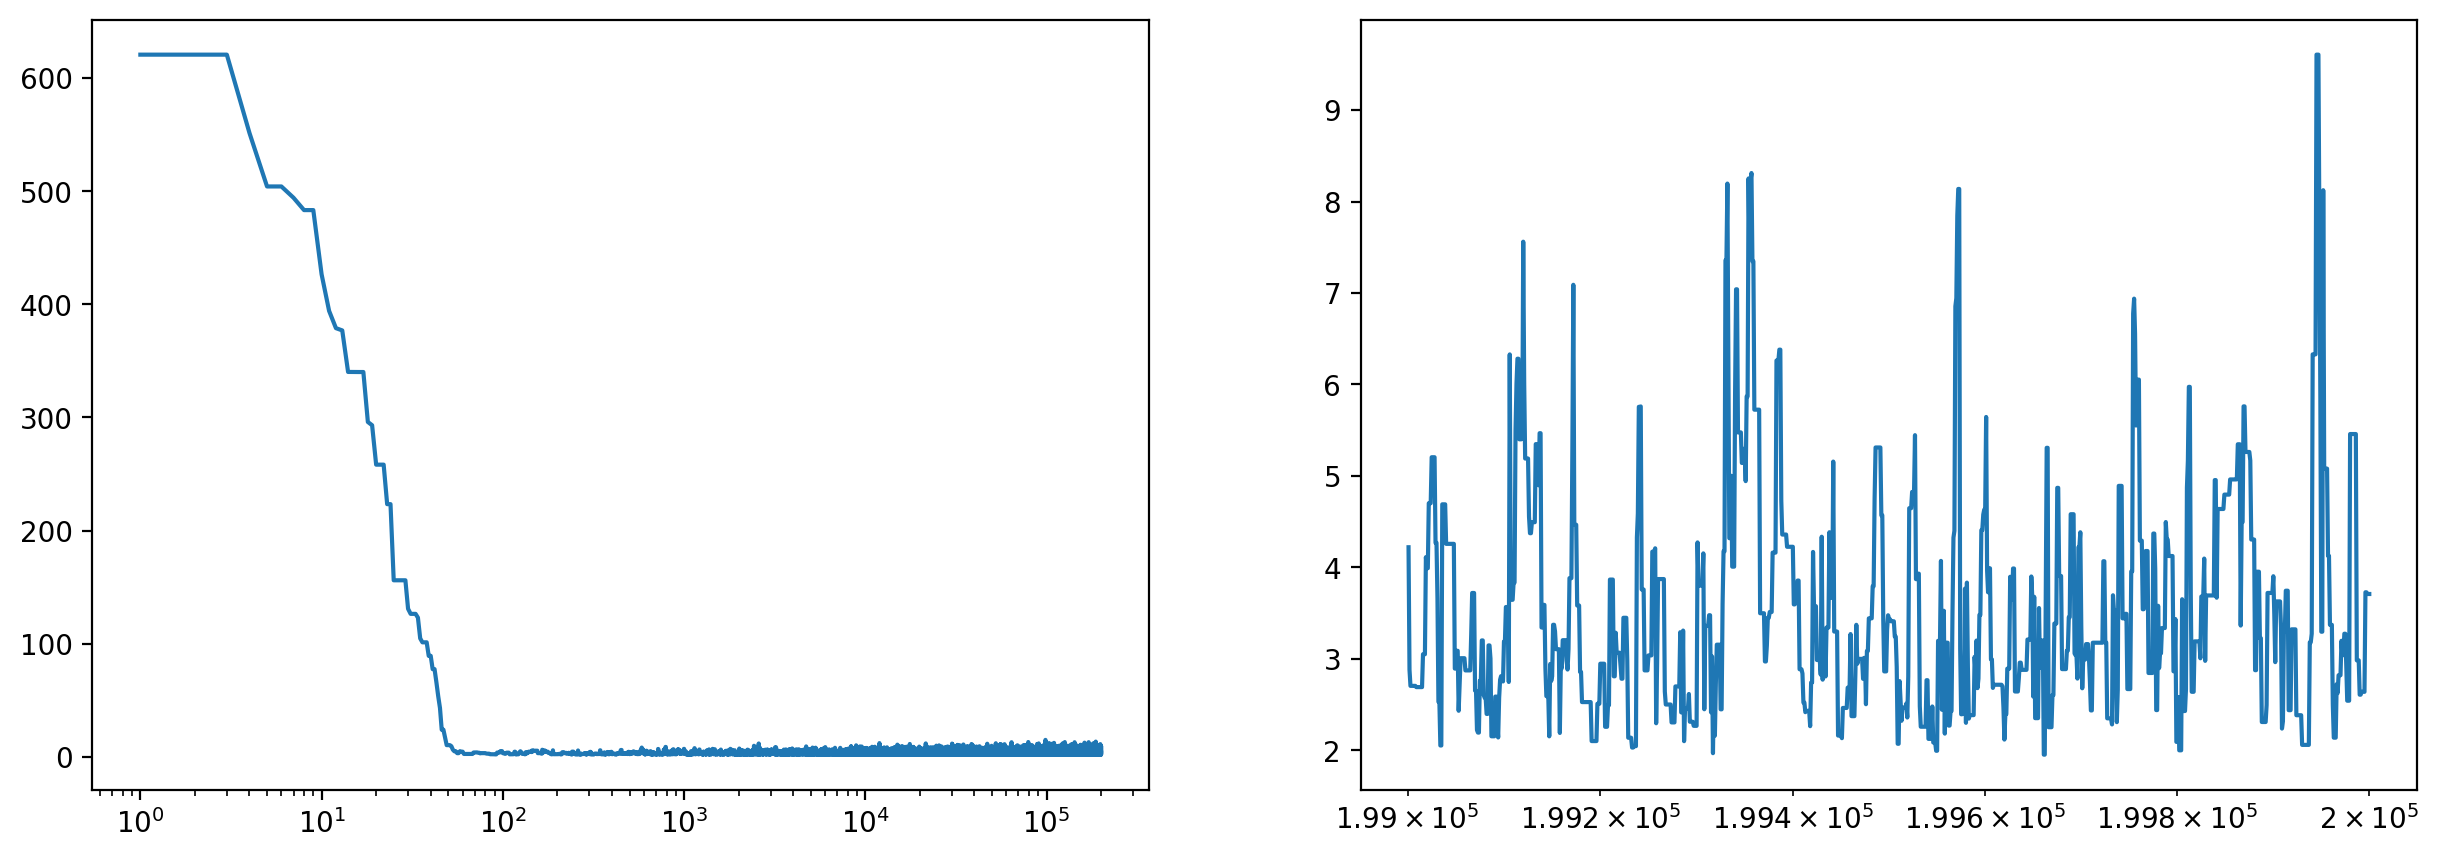

In [8]:
# Plot the log-posterior
x_logpost =  np.linspace(1,n_chain,n_chain)
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].plot(x_logpost,-post)
ax[0].set_xscale('log')
ax[1].plot(x_logpost[-1000:],-post[-1000:])
ax[1].set_xscale('log')
print("min logpost:", min(-post))
#plt.savefig('./output/convergence.jpg', bbox_inches='tight')

In [9]:
# Delete burning phase
burn_in = 10000
chain_wb = np.delete(chain,np.s_[0:burn_in],axis = 0)
print(chain_wb.shape)

(190000, 3)


In [10]:
# Calculate mean and covariance
mean = np.mean(chain_wb, axis = 0)
cov = np.cov(chain_wb, rowvar = False)
print(mean)
print(cov)

[-0.50067997  0.38660863  0.08847701]
[[ 2.31527135e-03  3.64768234e-06 -1.99349423e-04]
 [ 3.64768234e-06  1.54857267e-04 -2.69504599e-07]
 [-1.99349423e-04 -2.69504599e-07  3.04753642e-05]]


In [11]:
names = [r"\theta%s"%i for i in range(3)]
labels =  [r"\theta_%s"%i for i in range(3)]
samples = MCSamples(samples=chain_wb,names = names, labels = labels)

Removed no burn in


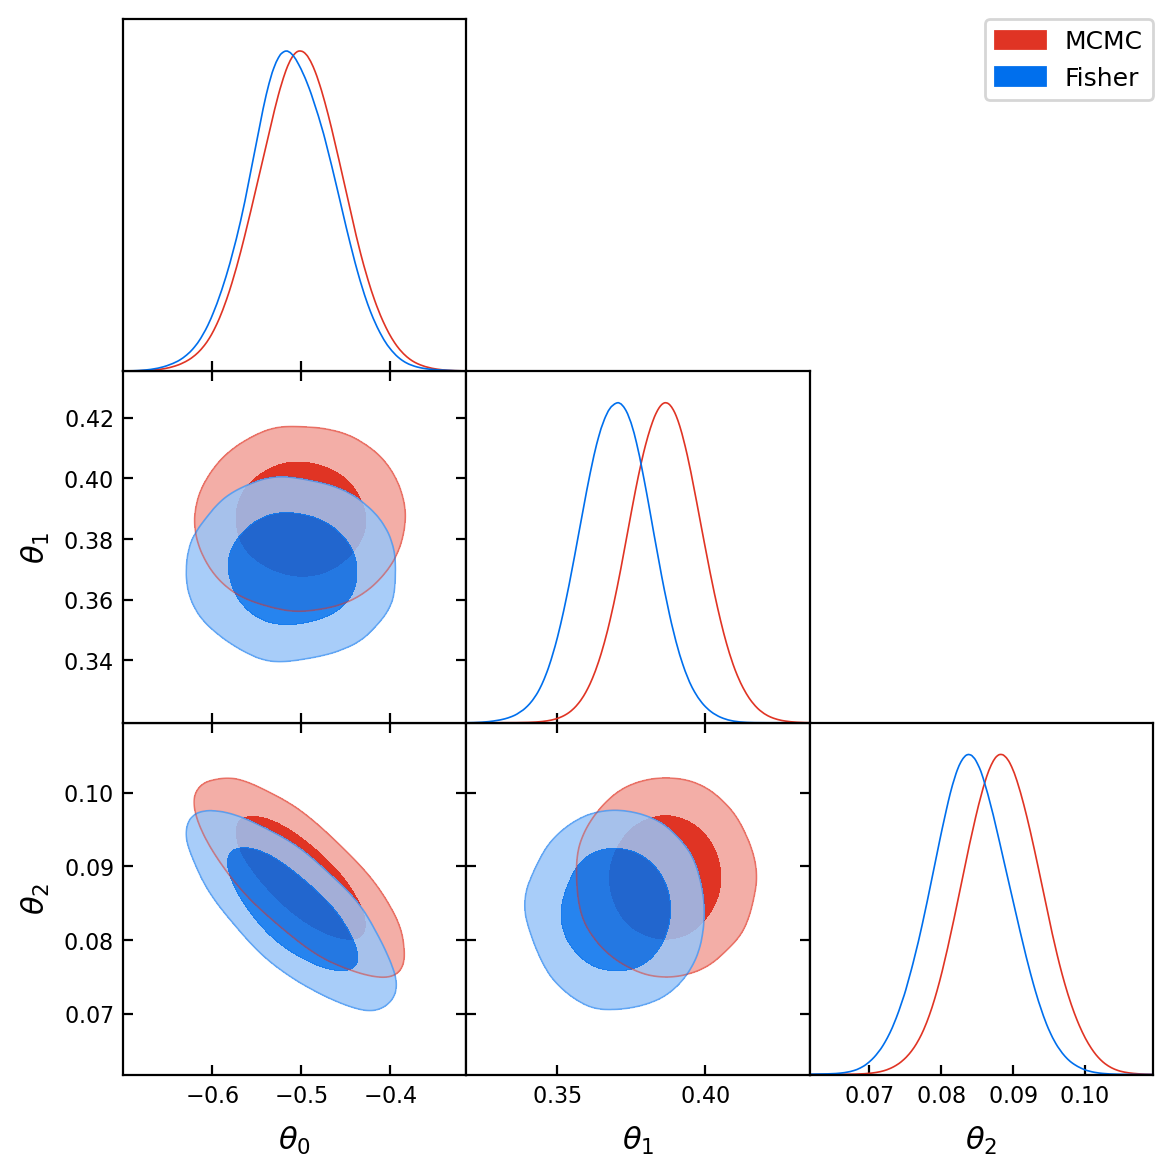

In [12]:
g = plots.get_subplot_plotter()
g.triangle_plot([samples, samples_fisher], filled=True, legend_labels= ['MCMC', 'Fisher'])
#plt.savefig('./output/corner_plot.jpg', bbox_inches='tight')

In [13]:
err = np.sqrt(np.diag(cov))
print(f"Results:{mean} +- {err}")
print(f"True values:{theta}")

Results:[-0.50067997  0.38660863  0.08847701] +- [0.04811727 0.01244417 0.00552045]
True values:[-0.51, 0.37, 0.084]
